V4.2 Update: in readme.md

In [1]:
# Check for TPU availability and set it up
import os

# Check if TPU is available
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    print("PyTorch XLA already installed")
    TPU_AVAILABLE = True
except ImportError:
    TPU_AVAILABLE = False
    print("PyTorch XLA not found, will attempt to install")

# Install necessary packages including PyTorch/XLA
!pip install pygame-ce pymunk stable-baselines3 stable-baselines3[extra] shimmy>=2.0 optuna
!pip install -q cloud-tpu-client

if not TPU_AVAILABLE:
    # Check what version of PyTorch we need
    import torch
    if torch.__version__.startswith('2'):
        # For PyTorch 2.x
        !pip install -q torch_xla[tpu]>=2.0
    else:
        # For PyTorch 1.x
        !pip install -q torch_xla

    # Restart runtime (required after installing PyTorch/XLA)
    print("TPU support installed. Please restart the runtime now.")
    import IPython
    IPython.display.display(IPython.display.HTML(
        "<script>google.colab.kernel.invokeFunction('notebook.Runtime.restartRuntime', [], {})</script>"
    ))
else:
    # Initialize TPU if available
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    print(f"XLA device detected: {device}")

PyTorch XLA not found, will attempt to install
TPU support installed. Please restart the runtime now.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!ls /content/

'=2.0'	 capture   game_history   logs	 models   sample_data


In [4]:
!rm -r /content/capture
!rm -r /content/game_history
!rm -r /content/logs

# Classes

## Recorder

In [16]:
import json
import os
import datetime

class Recorder:

    def __init__(self, task: str = "game_history_record"):
        """
        tasks:
        1. game_history_record
        2. temp_memory
        """
        # CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
        CURRENT_DIR = ""
        if task == "game_history_record":
            collection_name = self.get_newest_record_name()
            self.json_file_path = CURRENT_DIR + "./game_history/" + collection_name + ".json"

        # Ensure directory exists
        os.makedirs(os.path.dirname(self.json_file_path), exist_ok=True)

        if os.path.exists(self.json_file_path):
            print("Loading the json memory file")
            self.memory = self.load(self.json_file_path)
        else:
            print("The json memory file does not exist. Creating new file.")
            self.memory = {"game_records": []}  # Direct dictionary instead of json.loads
            with open(self.json_file_path, "w") as f:
                json.dump(self.memory, f)

    def get(self):
        print("Getting the json memory")
        return self.memory

    def add_no_limit(self, data: float, ):
        """
        Add a records.

        Args:
            role: The role of the sender (e.g., 'user', 'assistant')
            message: The message content
        """
        self.memory["game_records"].append({
            "game_total_duration": data,
            "timestamp": str(datetime.datetime.now())
        })

        self.save(self.json_file_path)

    def save(self, file_path):
        try:
            with open(file_path, 'w') as f:
                json.dump(self.memory, f)
        except Exception as e:
            print(f"Error saving memory to {file_path}: {e}")

    def load(self, file_path):
        try:
            with open(file_path, 'r') as f:
                return json.load(f)
        except Exception as e:
            print(f"Error loading memory from {file_path}: {e}")
            return {"game_records": []}

    def get_newest_record_name(self) -> str:
        """
        傳回最新的對話歷史資料和集的名稱 (game_YYYY_MM)
            - 例如: "game_2022-01"
        """

        this_month = datetime.datetime.now().strftime("%Y-%m")
        return "record_" + this_month

## Shapes & Objects

In [17]:
import pymunk
from typing import Tuple, Optional

class Shape:

    def __init__(
                self,
                position: Tuple[float, float] = (300, 100),
                velocity: Tuple[float, float] = (0, 0),
                body: Optional[pymunk.Body] = None,
                shape: Optional[pymunk.Shape] = None,
            ):
        """
        Initialize a physical shape with associated body.

        Args:
            position: Initial position (x, y) of the body
            velocity: Initial velocity (vx, vy) of the body
            body: The pymunk Body to attach to this shape
            shape: The pymunk Shape for collision detection
        """

        self.body = body
        self.default_position = position
        self.default_velocity = velocity
        self.body.position = position
        self.body.velocity = velocity
        self.default_angular_velocity = 0

        self.shape = shape

    def reset(self):
        """Reset the body to its default position, velocity and angular velocity."""
        self.body.position = self.default_position
        self.body.velocity = self.default_velocity
        self.body.angular_velocity = self.default_angular_velocity


In [18]:
import pymunk

# from shapes.shape import Shape
from typing import Tuple, Optional

class Circle(Shape):

    def __init__(
                self,
                position: Tuple[float, float] = (300, 100),
                velocity: Tuple[float, float] = (0, 0),
                body: Optional[pymunk.Body] = None,
                shape_radio: float = 20,
                shape_mass: float = 1,
                shape_friction: float = 0.1,
            ):
        """
        Initialize a circular physics object.

        Args:
            position: Initial position (x, y) of the circle
            velocity: Initial velocity (vx, vy) of the circle
            body: The pymunk Body to attach this circle to
            shape_radio: Radius of the circle in pixels
            shape_mass: Mass of the circle
            shape_friction: Friction coefficient for the circle
        """

        super().__init__(position, velocity, body)
        self.shape_radio = shape_radio
        self.shape = pymunk.Circle(self.body, shape_radio)
        self.shape.mass = shape_mass
        self.shape.friction = shape_friction
        self.shape.elasticity = 0.8  # Add some bounce to make the simulation more interesting


## Levels

In [19]:
import random
import time

class Levels:
    def __init__(self, space, window_x: int = 1000, window_y: int = 600):
        self.space = space
        self.window_x = window_x
        self.window_y = window_y

    def create_player(self,
                      window_x: int = 1000,
                      window_y: int = 600,
                     ):
        """Create the ball with physics properties"""
        dynamic_body = pymunk.Body()  # Ball body
        ball_radius = int(window_x / 67)
        player = Circle(
            position=(window_x / 2, window_y / 5),
            velocity=(0, 0),
            body=dynamic_body,
            shape_radio=ball_radius,
            shape_friction=100,
        )
        # Store initial values for reset
        default_player_position = (window_x / 2, window_y / 5)
        return {
            "type": "player",
            "shape": player,
            "default_position": default_player_position,
            "body": dynamic_body,
            "ball_radius": ball_radius,
        }

    def create_platform(self,
                        platform_shape: str = "circle",
                        platform_proportion: float = 0.4,
                        window_x: int = 1000,
                        window_y: int = 600,
                       ):
        """
        Create the platform with physics properties
        platform_shape: circle, rectangle
        platform_length: Length of a rectangle or Diameter of a circle
        """
        platform_length = int(window_x * platform_proportion)

        # Create game bodies
        kinematic_body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)  # Platform body
        kinematic_body.position = (window_x / 2, (window_y / 3) * 2)
        default_kinematic_position = kinematic_body.position

        if platform_shape == "circle":
            platform_length = platform_length / 2 # radius
            platform = pymunk.Circle(kinematic_body, platform_length)
            platform.mass = 1  # 质量对 Kinematic 物体无意义，但需要避免除以零错误
            platform.friction = 0.7

        elif platform_shape == "rectangle":
            platform_length = platform_length
            vs = [(-platform_length/2, -10),
                (platform_length/2, -10),
                (platform_length/2, 10),
                (-platform_length/2, 10)]

            platform = pymunk.Poly(kinematic_body, vs)
        platform.friction = 0.7
        platform.rotation = 0
        kinematic_body.angular_velocity = random.randrange(-1, 2, 2)

        return {
            "type": "platform",
            "shape": platform,
            "default_position": default_kinematic_position,
            "body": kinematic_body,
            "platform_length": platform_length,
        }


### Level1

In [20]:
class Level1(Levels):
    """
    Level 1: Basic setup with a dynamic body and a static kinematic body.
    """
    def __init__(self, space):
        super().__init__(space)
        self.space = space


    def setup(self, window_x, window_y):
        player = super().create_player(window_x=window_x, window_y=window_y)
        platform = super().create_platform(window_x=window_x, window_y=window_y)
        self.space.add(player["body"], player["shape"].shape)
        self.space.add(platform["body"], platform["shape"])
        self.dynamic_body = player["body"]
        self.kinematic_body = platform["body"]
        self.default_player_position = player["default_position"]

        return (player), (platform)

    def action(self):
        """
        shape state changes in the game
        """
        # Noting to do in this level
        pass

    def reset(self):
        """
        Reset the level to its initial state.
        """
        self.dynamic_body.position = self.default_player_position
        self.dynamic_body.angular_velocity = 0
        self.dynamic_body.velocity = (0, 0)
        self.kinematic_body.angular_velocity = random.randrange(-1, 2, 2)

        self.space.reindex_shapes_for_body(self.dynamic_body)
        self.space.reindex_shapes_for_body(self.kinematic_body)


### Level2

In [21]:
class Level2(Levels):
    """
    Level 1: Basic setup with a dynamic body and a static kinematic body.
    """
    def __init__(self, space):
        super().__init__(space)
        self.space = space
        self.last_angular_velocity_change_time = time.time()
        self.angular_velocity_change_timeout = 5 # sec


    def setup(self, window_x, window_y):
        player = super().create_player(window_x=window_x, window_y=window_y)
        platform = super().create_platform(window_x=window_x, window_y=window_y)
        self.space.add(player["body"], player["shape"].shape)
        self.space.add(platform["body"], platform["shape"])
        self.dynamic_body = player["body"]
        self.kinematic_body = platform["body"]
        self.default_player_position = player["default_position"]

        return (player), (platform)

    def action(self):
        """
        shape state changes in the game
        """

        if time.time() - self.last_angular_velocity_change_time > self.angular_velocity_change_timeout:
            self.kinematic_body.angular_velocity = random.randrange(-1, 2, 2)
            self.last_angular_velocity_change_time = time.time()

    def reset(self):
        """
        Reset the level to its initial state.
        """
        self.dynamic_body.position = self.default_player_position
        self.dynamic_body.angular_velocity = 0
        self.dynamic_body.velocity = (0, 0)
        self.kinematic_body.angular_velocity = random.randrange(-1, 2, 2)
        self.last_angular_velocity_change_time = time.time()

        self.space.reindex_shapes_for_body(self.dynamic_body)
        self.space.reindex_shapes_for_body(self.kinematic_body)


### Level3

In [22]:
class Level3:
    def __init__(dynamic_body, kinematic_body):
        pass

    def setup():
        pass

### --

In [23]:
def get_level(level: int, space):
    """
    Get the level object based on the level number.
    """
    if level == 1:
        return Level1(space)
    elif level == 2:
        return Level2(space)
    elif level == 3:
        return Level3()
    else:
        raise ValueError("Invalid level number")

## Game class

In [24]:
import pymunk
import pygame
import random
import time
import numpy as np
import os
import numpy as np
import base64
import matplotlib.pyplot as plt
import IPython.display as ipd

from typing import Dict, Tuple, Optional
from IPython.display import display, Image, clear_output
from io import BytesIO
# from shapes.circle import Circle
# from record import Recorder

class BalancingBallGame:
    """
    A physics-based balancing ball game that can run standalone or be used as a Gym environment.
    """

    # Game constants


    # Visual settings for indie style
    BACKGROUND_COLOR = (41, 50, 65)  # Dark blue background
    BALL_COLOR = (255, 213, 79)  # Bright yellow ball
    PLATFORM_COLOR = (235, 64, 52)  # Red platform
    PARTICLE_COLORS = [(252, 186, 3), (252, 127, 3), (252, 3, 3)]  # Fire-like particles



    def __init__(self,
                 render_mode: str = "human",
                 sound_enabled: bool = True,
                 difficulty: str = "medium",
                 window_x: int = 1000,
                 window_y: int = 600,
                 max_step: int = 30000,
                 player_ball_speed: int = 5,
                 reward_staying_alive: float = 0.1,
                 reward_ball_centered: float = 0.2,
                 penalty_falling: float = -10.0,
                 level: int = 2,
                 fps: int = 120,
                 platform_shape: str = "circle",
                 platform_proportion: int = 0.4,
                 capture_per_second: int = None,
                ):
        """
        Initialize the balancing ball game.

        Args:
            render_mode: "human" for visible window, "rgb_array" for gym env, "headless" for no rendering
            sound_enabled: Whether to enable sound effects
            difficulty: Game difficulty level ("easy", "medium", "hard")
            max_step: 1 step = 1/fps, if fps = 120, 1 step = 1/120
            reward_staying_alive: float = 0.1,
            reward_ball_centered: float = 0.2,
            penalty_falling: float = -10.0,
            fps: frame per second
            platform_proportion: platform_length = window_x * platform_proportion
            capture_per_second: save game screen as a image every second, None means no capture
        """
        # Game parameters
        self.max_step = max_step
        self.reward_staying_alive = reward_staying_alive
        self.reward_ball_centered = reward_ball_centered
        self.penalty_falling = penalty_falling
        self.fps = fps
        self.window_x = window_x
        self.window_y = window_y
        self.player_ball_speed = player_ball_speed

        self.recorder = Recorder("game_history_record")
        self.render_mode = render_mode
        self.sound_enabled = sound_enabled
        self.difficulty = difficulty

        platform_length = int(window_x * platform_proportion)
        self._get_x_axis_max_reward_rate(platform_length)

        # Initialize physics space
        self.space = pymunk.Space()
        self.space.gravity = (0, 1000)
        self.space.damping = 0.9

        # # Create game bodies
        # self.dynamic_body = pymunk.Body()  # Ball body
        # self.kinematic_body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)  # Platform body
        # self.kinematic_body.position = (self.window_x / 2, (self.window_y / 3) * 2)
        # self.default_kinematic_position = self.kinematic_body.position

        # # Create game objects
        # self._create_player()
        # self._create_platform(platform_shape=platform_shape, platform_length=platform_length)
        # # self._create_platform("rectangle")

        # # Add all objects to space
        # self.space.add(self.dynamic_body, self.kinematic_body,
        #                self.circle.shape, self.platform)

        self.level = get_level(level, self.space)
        player, platform = self.level.setup(self.window_x, self.window_y)
        self.dynamic_body = player["body"]
        self.kinematic_body = platform["body"]
        self.ball_radius = player["ball_radius"]
        self.platform_length = platform["platform_length"]

        # Game state tracking
        self.steps = 0
        self.start_time = time.time()
        self.game_over = False
        self.score = 0
        self.particles = []

        # Initialize Pygame if needed
        if self.render_mode in ["human", "rgb_array", "rgb_array_and_human", "rgb_array_and_human_in_colab"]:
            self._setup_pygame()
        else:
            print("render_mode is not human or rgb_array, so no pygame setup.")

        # Set difficulty parameters
        self._apply_difficulty()
        self.capture_per_second = capture_per_second

        # Create folders for captures if needed
        # CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
        CURRENT_DIR = "."
        os.makedirs(os.path.dirname(CURRENT_DIR + "/capture/"), exist_ok=True)

    def _setup_pygame(self):
        """Set up PyGame for rendering"""
        pygame.init()
        self.frame_count = 0

        if self.sound_enabled:
            self._load_sounds()

        if self.render_mode == "human":
            self.screen = pygame.display.set_mode((self.window_x, self.window_y))
            pygame.display.set_caption("Balancing Ball - Indie Game")
            self.font = pygame.font.Font(None, int(self.window_x / 34))

        elif self.render_mode == "rgb_array":
            self.screen = pygame.Surface((self.window_x, self.window_y))

        elif self.render_mode == "rgb_array_and_human": # todo
            print("rgb_array_and_human mode is not supported yet.")

        elif self.render_mode == "rgb_array_and_human_in_colab": # todo
            from pymunk.pygame_util import DrawOptions

            self.screen = pygame.Surface((self.window_x, self.window_y))  # Create hidden surface

            # Set up display in Colab
            self.draw_options = DrawOptions(self.screen)
            html_display = ipd.HTML('''
                <div id="pygame-output" style="width:100%;">
                    <img id="pygame-img" style="width:100%;">
                </div>
            ''')
            self.display_handle = display(html_display, display_id='pygame_display')

            self.last_update_time = time.time()
            self.update_interval = 1.0 / 15  # Update display at 15 FPS to avoid overwhelming Colab
            self.font = pygame.font.Font(None, int(self.window_x / 34))


        else:
            print("Invalid render mode. Using headless mode.")

        self.clock = pygame.time.Clock()

        # Create custom draw options for indie style

    def _load_sounds(self):
        """Load game sound effects"""
        try:
            pygame.mixer.init()
            self.sound_bounce = pygame.mixer.Sound("assets/bounce.wav") if os.path.exists("assets/bounce.wav") else None
            self.sound_fall = pygame.mixer.Sound("assets/fall.wav") if os.path.exists("assets/fall.wav") else None
        except Exception:
            print("Sound loading error")
            self.sound_enabled = False
            pass

    def _apply_difficulty(self):
        """Apply difficulty settings to the game"""
        if self.difficulty == "easy":
            self.max_platform_speed = 1.5
            self.ball_elasticity = 0.5
        elif self.difficulty == "medium":
            self.max_platform_speed = 2.5
            self.ball_elasticity = 0.7
        else:  # hard
            self.max_platform_speed = 3.5
            self.ball_elasticity = 0.9

        # self.circle.shape.elasticity = self.ball_elasticity

    def reset(self) -> np.ndarray:
        """Reset the game state and return the initial observation"""
        # Reset physics objects
        # self.dynamic_body.position = self.default_ball_position
        # self.dynamic_body.velocity = (0, 0)
        # self.dynamic_body.angular_velocity = 0

        # self.kinematic_body.position = self.default_kinematic_position
        # self.kinematic_body.angular_velocity = random.randrange(-1, 2, 2)
        self.level.reset()

        # Reset game state
        self.steps = 0
        self.start_time = time.time()
        self.game_over = False
        self.score = 0
        self.particles = []

        # Return initial observation
        return self._get_observation()

    def step(self, action: float) -> Tuple[np.ndarray, float, bool, Dict]:
        """
        Take a step in the game using the given action.

        Args:
            action: Float value between -1.0 and 1.0 controlling platform rotation

        Returns:
            observation: Game state observation
            reward: Reward for this step
            terminated: Whether episode is done
            info: Additional information
        """
        # Apply action to platform rotation
        if action == 0:
            action_value = (0 - self.player_ball_speed)
        elif action == 1:
            action_value = self.player_ball_speed
        elif action == 2:
            action_value = 0

        self.dynamic_body.angular_velocity += action_value
        self.level.action()

        # Step the physics simulation
        self.space.step(1/self.fps)

        # Update particle effects
        self._update_particles()

        # Check game state
        self.steps += 1
        terminated = False

        # Check if ball falls off screen
        ball_x = self.dynamic_body.position[0]
        # ball_y = self.dynamic_body.position[1]
        if (self.dynamic_body.position[1] > self.kinematic_body.position[1] or
            ball_x < 0 or
            ball_x > self.window_x or
            self.steps >= self.max_step
            ):

            print("Score: ", self.score)
            terminated = True
            reward = self.penalty_falling if self.steps < self.max_step else 0
            self.game_over = True

            result = {
                "game_total_duration": f"{time.time() - self.start_time:.2f}",
                "score": self.score,
            }
            self.recorder.add_no_limit(result)

            if self.sound_enabled and self.sound_fall:
                self.sound_fall.play()

        step_reward = self._reward_calculator(ball_x)
        self.score += step_reward
        # print("ball_x: ", ball_x, ", self.score: ", self.score)
        return self._get_observation(), step_reward, terminated

    def _get_observation(self) -> np.ndarray:
        """Convert game state to observation for RL agent"""
        # update particles and draw them
        screen_data = self.render() # 获取数据

        if self.capture_per_second is not None and self.frame_count % self.capture_per_second == 0:  # Every second at 60 FPS
            pygame.image.save(self.screen, f"capture/frame_{self.frame_count/60}.png")

        self.frame_count += 1
        return screen_data


    def _update_particles(self):
        """Update particle effects for indie visual style"""
        # Create new particles when ball hits platform
        if abs(self.dynamic_body.position[1] - (self.kinematic_body.position[1] - 20)) < 5 and abs(self.dynamic_body.velocity[1]) > 100:
            for _ in range(5):
                self.particles.append({
                    'x': self.dynamic_body.position[0],
                    'y': self.dynamic_body.position[1] + self.ball_radius,
                    'vx': random.uniform(-2, 2),
                    'vy': random.uniform(1, 3),
                    'life': 30,
                    'size': random.uniform(2, 5),
                    'color': random.choice(self.PARTICLE_COLORS)
                })

            if self.sound_enabled and self.sound_bounce:
                self.sound_bounce.play()

        # Update existing particles
        for particle in self.particles[:]:
            particle['x'] += particle['vx']
            particle['y'] += particle['vy']
            particle['life'] -= 1
            if particle['life'] <= 0:
                self.particles.remove(particle)

    def render(self) -> Optional[np.ndarray]:
        """Render the current game state"""
        if self.render_mode == "headless":
            return None

        # Clear screen with background color
        self.screen.fill(self.BACKGROUND_COLOR)

        # Custom drawing (for indie style)
        self._draw_indie_style()


        # Update display if in human mode
        if self.render_mode == "human":
            # Draw game information
            self._draw_game_info()
            pygame.display.flip()
            self.clock.tick(self.fps)
            return None

        elif self.render_mode == "rgb_array":
            # Return RGB array for gym environment
            return pygame.surfarray.array3d(self.screen)

        elif self.render_mode == "rgb_array_and_human": # todo
            print("rgb_array_and_human mode is not supported yet.")

        elif self.render_mode == "rgb_array_and_human_in_colab":
            self.space.debug_draw(self.draw_options)
            current_time = time.time()
            if current_time - self.last_update_time >= self.update_interval:
                # Convert Pygame surface to an image that can be displayed in Colab
                buffer = BytesIO()
                pygame.image.save(self.screen, buffer, 'PNG')
                buffer.seek(0)
                img_data = base64.b64encode(buffer.read()).decode('utf-8')

                # Update the HTML image
                self.display_handle.update(ipd.HTML(f'''
                    <div id="pygame-output" style="width:100%;">
                        <img id="pygame-img" src="data:image/png;base64,{img_data}" style="width:100%;">
                    </div>
                '''))

                self.last_update_time = current_time
            return pygame.surfarray.array3d(self.screen)
        else:
            pass

    def _draw_indie_style(self):
        """Draw game objects with indie game aesthetic"""
        # # Draw platform with gradient and glow
        # platform_points = []
        # for v in self.platform.get_vertices():
        #     x, y = v.rotated(self.kinematic_body.angle) + self.kinematic_body.position
        #     platform_points.append((int(x), int(y)))

        # pygame.draw.polygon(self.screen, self.PLATFORM_COLOR, platform_points)
        # pygame.draw.polygon(self.screen, (255, 255, 255), platform_points, 2)

        platform_pos = (int(self.kinematic_body.position[0]), int(self.kinematic_body.position[1]))
        pygame.draw.circle(self.screen, self.PLATFORM_COLOR, platform_pos, self.platform_length)
        pygame.draw.circle(self.screen, (255, 255, 255), platform_pos, self.platform_length, 2)

        # Draw rotation direction indicator
        self._draw_rotation_indicator(platform_pos, self.platform_length, self.kinematic_body.angular_velocity)

        # Draw ball with gradient and glow
        ball_pos = (int(self.dynamic_body.position[0]), int(self.dynamic_body.position[1]))
        pygame.draw.circle(self.screen, self.BALL_COLOR, ball_pos, self.ball_radius)
        pygame.draw.circle(self.screen, (255, 255, 255), ball_pos, self.ball_radius, 2)

        # Draw particles
        for particle in self.particles:
            alpha = min(255, int(255 * (particle['life'] / 30)))
            pygame.draw.circle(
                self.screen,
                particle['color'],
                (int(particle['x']), int(particle['y'])),
                int(particle['size'])
            )

    def _draw_rotation_indicator(self, position, radius, angular_velocity):
        """Draw an indicator showing the platform's rotation direction and speed"""
        # Only draw the indicator if there's some rotation
        if abs(angular_velocity) < 0.1:
            return

        # Calculate indicator properties based on angular velocity
        indicator_color = (50, 255, 150) if angular_velocity > 0 else (255, 150, 50)
        num_arrows = min(3, max(1, int(abs(angular_velocity))))
        indicator_radius = radius - 20  # Place indicator inside the platform

        # Draw arrow indicators along the platform's circumference
        start_angle = self.kinematic_body.angle

        for i in range(num_arrows):
            # Calculate arrow position
            arrow_angle = start_angle + i * (2 * np.pi / num_arrows)

            # Calculate arrow start and end points
            base_x = position[0] + int(np.cos(arrow_angle) * indicator_radius)
            base_y = position[1] + int(np.sin(arrow_angle) * indicator_radius)

            # Determine arrow direction based on angular velocity
            if angular_velocity > 0:  # Clockwise
                arrow_end_angle = arrow_angle + 0.3
            else:  # Counter-clockwise
                arrow_end_angle = arrow_angle - 0.3

            tip_x = position[0] + int(np.cos(arrow_end_angle) * (indicator_radius + 15))
            tip_y = position[1] + int(np.sin(arrow_end_angle) * (indicator_radius + 15))

            # Draw arrow line
            pygame.draw.line(self.screen, indicator_color, (base_x, base_y), (tip_x, tip_y), 3)

            # Draw arrowhead
            arrowhead_size = 7
            pygame.draw.circle(self.screen, indicator_color, (tip_x, tip_y), arrowhead_size)

    def _draw_game_info(self):
        """Draw game information on screen"""
        # Create texts
        time_text = f"Time: {time.time() - self.start_time:.1f}"
        score_text = f"Score: {self.score}"

        # Render texts
        time_surface = self.font.render(time_text, True, (255, 255, 255))
        score_surface = self.font.render(score_text, True, (255, 255, 255))

        # Draw text backgrounds
        pygame.draw.rect(self.screen, (0, 0, 0, 128),
                        (5, 5, time_surface.get_width() + 10, time_surface.get_height() + 5))
        pygame.draw.rect(self.screen, (0, 0, 0, 128),
                        (self.window_x - score_surface.get_width() - 15, 5,
                         score_surface.get_width() + 10, score_surface.get_height() + 5))

        # Draw texts
        self.screen.blit(time_surface, (10, 10))
        self.screen.blit(score_surface, (self.window_x - score_surface.get_width() - 10, 10))

        # Draw game over screen
        if self.game_over:
            game_over_text = "GAME OVER - Press R to restart"
            game_over_surface = self.font.render(game_over_text, True, (255, 255, 255))

            # Draw semi-transparent background
            overlay = pygame.Surface((self.window_x, self.window_y), pygame.SRCALPHA)
            overlay.fill((0, 0, 0, 128))
            self.screen.blit(overlay, (0, 0))

            # Draw text
            self.screen.blit(game_over_surface,
                           (self.window_x/2 - game_over_surface.get_width()/2,
                            self.window_y/2 - game_over_surface.get_height()/2))

    def _get_x_axis_max_reward_rate(self, platform_length):
        """
        ((self.platform_length / 2) - 5) for calculate the distance to the
        center of game window coordinates. The closer you are, the higher the reward.

        When the ball is to be 10 points away from the center coordinates,
        it should be 1 - ((self.platform_length - 10) * self.x_axis_max_reward_rate)
        """
        self.reward_width = (platform_length / 2) - 5
        self.x_axis_max_reward_rate = 2 / self.reward_width
        print("self.x_axis_max_reward_rate: ", self.x_axis_max_reward_rate)

    def _reward_calculator(self, ball_x):
        # score & reward
        step_reward = 1/100

        rw = abs(ball_x - self.window_x/2)
        if rw < self.reward_width:
            x_axis_reward_rate = 1 + ((self.reward_width - abs(ball_x - self.window_x/2)) * self.x_axis_max_reward_rate)
            step_reward = self.steps * 0.01 * x_axis_reward_rate  # Simplified reward calculation

            if self.steps % 500 == 0:
                step_reward += self.steps/100
                print("check point: ", self.steps/500)

            return step_reward
        else:
            return 0

    def _reward_calculator2(self, ball_x):
        # Base reward for staying alive
        step_reward = 0.1

        # Distance from center (normalized)
        distance_from_center = abs(ball_x - self.window_x/2) / (self.window_x/2)

        # Smooth reward based on position (highest at center)
        position_reward = max(0, 1.0 - distance_from_center)

        # Apply position reward (with higher weight for better position)
        step_reward += position_reward * 0.3

        # Small bonus for surviving longer (but not dominant)
        survival_bonus = min(0.2, self.steps / 10000)
        step_reward += survival_bonus

        # Checkpoint bonuses remain meaningful but don't explode
        if self.steps % 1000 == 0 and self.steps > 0:
            step_reward += 1.0
            print(f"Checkpoint reached: {self.steps}")

        return step_reward

    def close(self):
        """Close the game and clean up resources"""
        if self.render_mode in ["human", "rgb_array"]:
            pygame.quit()

    def run_standalone(self):
        """Run the game in standalone mode with keyboard controls"""
        if self.render_mode not in ["human", "rgb_array_and_human_in_colab"]:
            raise ValueError("Standalone mode requires render_mode='human' or 'rgb_array_and_human_in_colab'")

        running = True
        while running:
            # Handle events
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                elif event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_r and self.game_over:
                        self.reset()

            # Process keyboard controls
            keys = pygame.key.get_pressed()
            # In order to fit the model action space, the model can currently only output 0 and 1, so 2 is no action
            action = 2
            if keys[pygame.K_LEFT]:
                action = 0
            if keys[pygame.K_RIGHT]:
                action = 1

            # Take game step
            if not self.game_over:
                self.step(action)

            # Render
            self.render()

        self.close()

## GYM env

In [25]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import cv2

# from balancing_ball_game import BalancingBallGame

class BalancingBallEnv(gym.Env):
    """
    Gymnasium environment for the Balancing Ball game
    """
    metadata = {'render_modes': ['human', 'rgb_array', 'rgb_array_and_human_in_colab']}

    def __init__(self,
                 render_mode="rgb_array",
                 difficulty="medium",
                 level=2,
                 fps=30,
                 obs_type="game_screen",
                 image_size=(84, 84),
                ):
        """
        render_mode: how to render the environment
            Example: "human" or "rgb_array"
        fps: Frames per second,
            Example: 30
        obs_type: type of observation
            Example: "game_screen" or "state_based"
        image_size: Size to resize images to (height, width)
            Example: (84, 84) - standard for many RL implementations
        """

        super(BalancingBallEnv, self).__init__()

        # Action space: discrete - 0: left, 1: right
        self.action_space = spaces.Discrete(2)

        # Initialize game
        self.window_x = 300
        self.window_y = 180
        self.platform_shape = "circle"
        self.platform_proportion = 0.333

        # Image preprocessing settings
        self.image_size = image_size

        self.stack_size = 3  # Number of frames to stack
        self.observation_stack = []  # Initialize the stack
        self.render_mode = render_mode

        self.game = BalancingBallGame(
            render_mode=render_mode,
            sound_enabled=(render_mode == "human"),
            difficulty=difficulty,
            window_x = self.window_x,
            window_y = self.window_y,
            level = level,
            fps = fps,
            platform_shape = self.platform_shape,
            platform_proportion = self.platform_proportion,
        )

        if obs_type == "game_screen":
            channels = 1

            # Image observation space with stacked frames
            self.observation_space = spaces.Box(
                low=0, high=255,
                shape=(self.image_size[0], self.image_size[1], channels * self.stack_size),
                dtype=np.uint8,
            )
            self.step = self.step_game_screen
            self.reset = self.reset_game_screen
        elif obs_type == "state_based":
            # State-based observation space: [ball_x, ball_y, ball_vx, ball_vy, platform_x, platform_y, platform_angular_velocity]
            # Normalize values to be between -1 and 1
            self.observation_space = spaces.Box(
                low=np.array([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]),
                high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
                dtype=np.float32
            )
            self.step = self.step_state_based
            self.reset = self.reset_state_based
        else:
            raise ValueError("obs_type must be 'game_screen' or 'state_based'")

        # Platform_length /= 2 when for calculate the distance to the
        # center of game window coordinates. The closer you are, the higher the reward.
        self.platform_reward_length = (self.game.platform_length / 2) - 5

        # When the ball is to be 10 points away from the center coordinates,
        # it should be 1 - ((self.platform_length - 10) * self.x_axis_max_reward_rate)
        self.x_axis_max_reward_rate = 0.5 / self.platform_reward_length

    def _preprocess_observation(self, observation):
        """Process raw game observation for RL training

        Args:
            observation: RGB image from the game

        Returns:
            Processed observation ready for RL
        """
        observation = np.transpose(observation, (1, 0, 2))

        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        observation = np.expand_dims(observation, axis=-1)  # Add channel dimension back

        # Resize to target size
        if observation.shape[0] != self.image_size[0] or observation.shape[1] != self.image_size[1]:
            # For grayscale, temporarily remove the channel dimension for cv2.resize
            observation = cv2.resize(
                observation.squeeze(-1),
                (self.image_size[1], self.image_size[0]),
                interpolation=cv2.INTER_AREA
            )
            observation = np.expand_dims(observation, axis=-1)  # Add channel dimension back

        return observation

    def step_game_screen(self, action):
        """Take a step in the environment"""
        # Take step in the game
        obs, step_reward, terminated = self.game.step(action)

        # Preprocess the observation
        obs = self._preprocess_observation(obs)

        time.sleep(0.1)

        # Stack the frames
        self.observation_stack.append(obs)
        if len(self.observation_stack) > self.stack_size:
            self.observation_stack.pop(0)  # Remove the oldest frame

        # If the stack isn't full yet, pad it with the current frame
        while len(self.observation_stack) < self.stack_size:
            self.observation_stack.insert(0, obs)  # Pad with current frame at the beginning

        stacked_obs = np.concatenate(self.observation_stack, axis=-1)

        # Gymnasium expects (observation, reward, terminated, truncated, info)
        return stacked_obs, step_reward, terminated, False, {}

    def reset_game_screen(self, seed=None, options=None):
        """Reset the environment"""
        super().reset(seed=seed)  # This properly seeds the environment in Gymnasium

        observation = self.game.reset()

        # Preprocess the observation
        observation = self._preprocess_observation(observation)

        # Reset the observation stack
        self.observation_stack = []

        # Fill the stack with the initial observation
        for _ in range(self.stack_size):
            self.observation_stack.append(observation)

        # Create stacked observation
        stacked_obs = np.concatenate(self.observation_stack, axis=-1)

        info = {}
        return stacked_obs, info

    def _get_state_based_observation(self):
        """Convert game state to state-based observation for RL agent"""
        # Normalize positions by window dimensions
        ball_x = self.game.dynamic_body.position[0] / self.window_x * 2 - 1  # Convert to [-1, 1]
        ball_y = self.game.dynamic_body.position[1] / self.window_y * 2 - 1  # Convert to [-1, 1]

        # Normalize velocities (assuming max velocity around 1000)
        max_velocity = 1000
        ball_vx = np.clip(self.game.dynamic_body.velocity[0] / max_velocity, -1, 1)
        ball_vy = np.clip(self.game.dynamic_body.velocity[1] / max_velocity, -1, 1)

        # Normalize platform position
        platform_x = self.game.kinematic_body.position[0] / self.window_x * 2 - 1  # Convert to [-1, 1]
        platform_y = self.game.kinematic_body.position[1] / self.window_y * 2 - 1  # Convert to [-1, 1]

        # Normalize angular velocity (assuming max around 10)
        max_angular_velocity = 10
        platform_angular_velocity = np.clip(self.game.kinematic_body.angular_velocity / max_angular_velocity, -1, 1)

        return np.array([
            ball_x,
            ball_y,
            ball_vx,
            ball_vy,
            platform_x,
            platform_y,
            platform_angular_velocity
        ], dtype=np.float32)

    def step_state_based(self, action):
        """Take a step in the environment"""
        # Take step in the game
        _, step_reward, terminated = self.game.step(action)

        # Get state-based observation
        observation = self._get_state_based_observation()

        # Gymnasium expects (observation, reward, terminated, truncated, info)
        return observation, step_reward, terminated, False, {}

    def reset_state_based(self, seed=None, options=None):
        """Reset the environment"""
        super().reset(seed=seed)  # This properly seeds the environment in Gymnasium

        self.game.reset()
        observation = self._get_state_based_observation()

        info = {}
        return observation, info

    def render(self):
        """Render the environment"""
        return self.game.render()

    def close(self):
        """Clean up resources"""
        self.game.close()

## Test

In [26]:
# from balancing_ball_game import BalancingBallGame

def run_standalone_game(render_mode="human", difficulty="medium", capture_per_second=3, window_x=1000, window_y=600, level=2):
    """Run the game in standalone mode with visual display"""

    platform_shape = "circle"
    platform_proportion = 0.333

    game = BalancingBallGame(
        render_mode = render_mode,
        difficulty = difficulty,
        window_x = window_x,
        window_y = window_y,
        platform_shape = platform_shape,
        platform_proportion = platform_proportion,
        level = level,
        fps = 30,
        capture_per_second = 3,
    )

    game.run_standalone()

def test_gym_env(episodes=3, difficulty="medium"):
    """Test the OpenAI Gym environment"""
    import time
    # from gym_env import BalancingBallEnv

    fps = 30
    env = BalancingBallEnv(
        render_mode="rgb_array_and_human_in_colab",
        difficulty=difficulty,
        fps=fps,
    )

    for episode in range(episodes):
        observation, info = env.reset()
        total_reward = 0
        step = 0
        done = False

        while not done:
            # Sample a random action (for testing only)
            action = env.action_space.sample()

            # Take step
            observation, reward, terminated, truncated, _ = env.step(action)

            done = terminated or truncated
            total_reward += reward
            step += 1

            # Render
            env.render()

        print(f"Episode {episode+1}: Steps: {step}, Total Reward: {total_reward:.2f}")

    env.close()

## Train

In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import sys
import optuna

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy, ActorCriticCnnPolicy  # MLP policy instead of CNN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

class Train:
    def __init__(self,
                 learning_rate=0.0003,
                 n_steps=2048,
                 batch_size=64,
                 n_epochs=10,
                 gamma=0.99,
                 gae_lambda=0.95,
                 ent_coef=0.01,
                 vf_coef=0.5,
                 max_grad_norm=0.5,
                 policy_kwargs=None,
                 n_envs=4,
                 difficulty="medium",
                 level=2,
                 load_model=None,
                 log_dir="./logs/",
                 model_dir="./models/",
                 obs_type="game_screen",
                ):

        # Create directories
        os.makedirs(log_dir, exist_ok=True)
        os.makedirs(model_dir, exist_ok=True)
        self.log_dir = log_dir
        self.model_dir = model_dir
        self.n_envs = n_envs
        self.obs_type = obs_type
        self.level = level

        # Setup environments
        env = make_vec_env(
            self.make_env(render_mode="rgb_array_and_human_in_colab", difficulty=difficulty, obs_type=obs_type),
            n_envs=n_envs
        )
        self.env = env  # No need for VecTransposeImage with state-based observations

        # Setup evaluation environment
        eval_env = make_vec_env(
            self.make_env(render_mode="rgb_array_and_human_in_colab", difficulty=difficulty, obs_type=obs_type),
            n_envs=1
        )
        self.eval_env = eval_env  # No need for VecTransposeImage

        # Create the PPO model
        if load_model:
            print(f"Loading model from {load_model}")
            self.model = PPO.load(
                load_model,
                env=self.env,
                tensorboard_log=log_dir,
            )
        else:
            hyper_param = {
                'learning_rate': 0.0003,
                'gamma': 0.99,
                'clip_range': 0.2,
                'gae_lambda': 0.95,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
            }
            # hyper_param = {
            #     'learning_rate': 9.610262132782771e-05,
            #     'gamma': 0.9354902732764846,
            #     'clip_range': 0.10781723398003445,
            #     'gae_lambda': 0.7317659739640645,
            #     'ent_coef': 0.04688706780862235,
            #     'vf_coef': 0.9117913569235723,
            # }
            policy_kwargs = {
                "features_extractor_kwargs": {"features_dim": 512},
                "net_arch": [256, 256],  # MLP architecture
            }

            policy = ActorCriticCnnPolicy if obs_type == "game_screen" else ActorCriticPolicy
            print("obs type: ", self.obs_type)
            print("policy: ", policy)
            # MLP policy for state-based observations, CNN policy for image-based observations
            self.model = PPO(
                policy=policy,
                env=self.env,
                learning_rate=hyper_param["learning_rate"],
                n_steps=n_steps,
                batch_size=batch_size,
                n_epochs=n_epochs,
                gamma=hyper_param["gamma"],
                clip_range=hyper_param["clip_range"],
                gae_lambda=hyper_param["gae_lambda"],
                ent_coef=hyper_param["ent_coef"],
                vf_coef=hyper_param["vf_coef"],
                max_grad_norm=max_grad_norm,
                tensorboard_log=log_dir,
                policy_kwargs=policy_kwargs,
                verbose=1,
            )

    def make_env(self, render_mode="rgb_array", difficulty="medium", obs_type="game_screen"):
        """
        Create and return an environment function to be used with VecEnv
        """
        def _init():
            env = BalancingBallEnv(render_mode=render_mode, difficulty=difficulty, level=self.level, obs_type=obs_type)
            return env
        return _init

    def train_ppo(self,
                  total_timesteps=1000000,
                  save_freq=10000,
                  eval_freq=10000,
                  eval_episodes=5,
                 ):
        """
        Train a PPO agent to play the Balancing Ball game

        Args:
            total_timesteps: Total number of steps to train for
            n_envs: Number of parallel environments
            save_freq: How often to save checkpoints (in timesteps)
            log_dir: Directory for tensorboard logs
            model_dir: Directory to save models
            eval_freq: How often to evaluate the model (in timesteps)
            eval_episodes: Number of episodes to evaluate on
            difficulty: Game difficulty level
            load_model: Path to model to load for continued training
        """

        # Setup callbacks
        checkpoint_callback = CheckpointCallback(
            save_freq=save_freq // self.n_envs,  # Divide by n_envs as save_freq is in timesteps
            save_path=self.model_dir,
            name_prefix="ppo_balancing_ball_" + str(self.obs_type),
        )

        eval_callback = EvalCallback(
            self.eval_env,
            best_model_save_path=self.model_dir,
            log_path=self.log_dir,
            eval_freq=eval_freq // self.n_envs,
            n_eval_episodes=eval_episodes,
            deterministic=True,
            render=False
        )

        # Train the model
        print("Starting training...")
        self.model.learn(
            total_timesteps=total_timesteps,
            callback=[checkpoint_callback, eval_callback],
        )

        # Save the final model
        self.model.save(f"{self.model_dir}/ppo_balancing_ball_final_" + str(self.obs_type))

        print("Training completed!")
        return self.model

    def evaluate(self, model_path, n_episodes=10, difficulty="medium"):
        """
        Evaluate a trained model

        Args:
            model_path: Path to the saved model
            n_episodes: Number of episodes to evaluate on
            difficulty: Game difficulty level
        """
        # Load the model
        model = PPO.load(model_path)

        # Evaluate
        mean_reward, std_reward = evaluate_policy(
            model,
            self.env,
            n_eval_episodes=n_episodes,
            deterministic=True,
            render=True
        )

        print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

        self.env.close()


# if args.mode == "train":
#     train_ppo(
#         total_timesteps=args.timesteps,
#         difficulty=args.difficulty,
#         n_envs=args.n_envs,
#         load_model=args.load_model,
#         eval_episodes=args.eval_episodes,
#     )
# else:
#     if args.load_model is None:
#         print("Error: Must provide --load_model for evaluation")
#     else:
#         evaluate(
#             model_path=args.load_model,
#             n_episodes=args.eval_episodes,
#             difficulty=args.difficulty
#         )


## Optuna

In [28]:
class Optuna_optimize:
    def __init__(self, obs_type="game_screen"):
        self.obs_type = obs_type
        self.env = make_vec_env(
            self.make_env(render_mode="rgb_array", difficulty="medium", obs_type=self.obs_type),
            n_envs=1
        )

    def make_env(self, render_mode="rgb_array", difficulty="medium", obs_type="game_screen"):
        """
        Create and return an environment function to be used with VecEnv
        """
        def _init():
            env = BalancingBallEnv(render_mode=render_mode, difficulty=difficulty, obs_type=obs_type)
            return env
        return _init

    def optuna_parameter_tuning(self, n_trials):
        print("You are using optuna for automatic parameter tuning, it will create a new model")

        pruner = optuna.pruners.HyperbandPruner(
            min_resource=100,        # 最小资源量
            max_resource='auto',   # 最大资源量 ('auto' 或 整数)
            reduction_factor=3     # 折减因子 (eta)
        )

        # 建立 study 物件，並指定剪枝器
        study = optuna.create_study(direction='maximize', pruner=pruner)

        # 執行優化
        try:
            study.optimize(self.objective, n_trials=n_trials)

            # 分析結果
            print("最佳試驗的超參數：", study.best_trial.params)
            print("最佳試驗的平均回報：", study.best_trial.value)

            import pandas as pd
            df = study.trials_dataframe()
            print(df.head())
        finally:
            self.env.close()
            del self.env


    def objective(self, trial):
        import gc

        # 1. 建議超參數
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        gamma = trial.suggest_float('gamma', 0.9, 0.999)
        clip_range = trial.suggest_float('clip_range', 0.1, 0.3)
        gae_lambda = trial.suggest_float('gae_lambda', 0.5, 2)
        ent_coef = trial.suggest_float('ent_coef', 0.005, 0.05)
        vf_coef = trial.suggest_float('vf_coef', 0.1, 1)
        features_dim = trial.suggest_categorical('features_dim', [32, 64, 128, 256, 512])
        policy_kwargs = {
            "features_extractor_kwargs": {"features_dim": features_dim},
            "net_arch": [256, 256],  # MLP architecture
        }

        n_steps=2048
        batch_size=64
        n_epochs=10
        # gamma=0.99
        # gae_lambda=0.95
        # ent_coef=0.01
        # vf_coef=0.5
        max_grad_norm=0.5

        # 2. 建立環境


        policy = ActorCriticCnnPolicy if self.obs_type == "game_screen" else ActorCriticPolicy
        print("obs type: ", self.obs_type)
        print("policy: ", policy)
        # 3. 建立模型
        model = PPO(
                policy=policy,  # MLP policy for state-based observations
                env=self.env,
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                n_epochs=n_epochs,
                gamma=gamma,
                clip_range=clip_range,
                gae_lambda=gae_lambda,
                ent_coef=ent_coef,
                vf_coef=vf_coef,
                max_grad_norm=max_grad_norm,
                tensorboard_log=None,
                policy_kwargs=policy_kwargs,
                verbose=0,
            )

        try:
            # 4. 訓練模型
            model.learn(total_timesteps=30000)
            # 5. 評估模型
            mean_reward = evaluate_policy(model, self.env, n_eval_episodes=10)[0]
        finally:
            # Always cleanup
            del model
            gc.collect()

            if TPU_AVAILABLE:
                import torch_xla.core.xla_model as xm
                xm.mark_step()

        return mean_reward

# Training

The json memory file does not exist. Creating new file.
self.x_axis_max_reward_rate:  0.0449438202247191


Loading the json memory file
self.x_axis_max_reward_rate:  0.0449438202247191



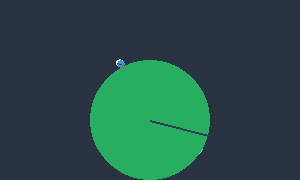

obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Using cuda device
Wrapping the env in a VecTransposeImage.
Starting training...
Logging to ./logs/PPO_2


c:\Users\User\Desktop\AI\Balancing_Ball_for_RL\.conda\Lib\site-packages\stable_baselines3\common\callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x000002530BE5B610> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000002532CCFACD0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Score:  13.104452732905127
Score:  18.166712733706902
Score:  6.842190326301453
Score:  11.30030661851889
Score:  9.127875585841176
Score:  13.604410677608081
Score:  8.743324659461782


KeyboardInterrupt: 

In [29]:
import gc

# Memory-optimized training setup
def get_tpu_memory_info():
    """Get memory information from TPU device if available"""
    # if TPU_AVAILABLE:
    #     try:
    #         # This is just for diagnostic purposes
    #         import subprocess
    #         result = subprocess.run(['python3', '-c', 'import torch_xla; print(torch_xla._XLAC._xla_get_memory_info(torch_xla._XLAC._xla_get_default_device()))'],
    #                                stdout=subprocess.PIPE, text=True)
    #         print(f"TPU Memory Info: {result.stdout}")
    #     except:
    #         print("Could not get detailed TPU memory info")
    pass

# Display memory information
get_tpu_memory_info()

n_envs = 1
batch_size = 64
n_steps = 2048

# Choose whether to do hyperparameter optimization or direct training
do_optimization = False

if do_optimization:
    optuna_optimizer = Optuna_optimize(obs_type="game_screen")
    # # Force TPU memory cleanup before starting
    # if TPU_AVAILABLE:
    #     gc.collect()
    #     xm.mark_step()

    n_trials = 10
    best_trial = optuna_optimizer.optuna_parameter_tuning(n_trials=n_trials)
    print(f"best_trial found: {best_trial}")
else:
    # Create trainer
    training = Train(
        n_steps=n_steps,
        batch_size=batch_size,
        difficulty="medium",
        n_envs=n_envs,
        level=1,
        load_model=None,  # Start fresh with state-based env
        obs_type='game_screen',
    )
    # Run training with memory-optimized settings
    # Use fewer total timesteps for TPU to avoid memory issues
    total_timesteps = 250000

    model = training.train_ppo(
        total_timesteps=total_timesteps,
        eval_episodes=3,  # Fewer eval episodes on TPU
        save_freq=5000,
        eval_freq=5000
    )

    # # Force memory cleanup after training
    # if TPU_AVAILABLE:
    #     del model
    #     gc.collect()
    #     xm.mark_step()

In [ ]:
# Copy the best model to a stable location
!cp /content/models/best_model.zip /content/drive/MyDrive/RL_Models/best_model_$(date +%Y%m%d_%H%M%S).zip

# Optional: Monitor TPU usage
if TPU_AVAILABLE:
    !sudo lsof -w /dev/accel0

In [ ]:
# Load a saved model and continue training or evaluate
model_path = "/content/models/best_model.zip"

if os.path.exists(model_path):
    print(f"Loading model from {model_path} for evaluation")

    # Create trainer with the saved model
    eval_trainer = Train(
        n_steps=1024,
        batch_size=batch_size,
        difficulty="medium",
        n_envs=1  # Use 1 env for evaluation
    )

    # Evaluate the model
    eval_trainer.evaluate(
        model_path=model_path,
        n_episodes=5,
        difficulty="medium"
    )
else:
    print(f"Model not found at {model_path}")

# --

In [ ]:
# run_standalone_game(render_mode="rgb_array_and_human_in_colab", difficulty="medium", window_x=1000, window_y=600)
test_gym_env(difficulty="medium")

In [ ]:
# Example of creating the environment with grayscale images
env = BalancingBallEnv(
    render_mode="rgb_array",
    difficulty="medium",
    fps=30,
    obs_type="game_screen",
    image_size=(84, 84)  # Standard size for many RL frameworks
)

# Reset environment to get initial observation
obs, info = env.reset()

# Print observation shape to verify
print(f"Observation shape: {obs.shape}")  # Should be (84, 84, 3) for grayscale with 3 stacked frames

# Display a sample observation (first frame only)
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.imshow(obs[:,:,0], cmap='gray')
plt.title("Grayscale Observation (First Frame)")
plt.axis('off')
plt.show()